# Using non-orbitize! Posteriors as Priors

By Jorge Llop-Sayson (2021)

This tutorial shows how to use posterior distribution from any source as `orbitize!` priors using a Kernel Density Estimator (KDE).

The user will need their posterior chains, consisiting of any number of correlated parameters, which will be used to get a KDE fit of the chains to be used as priors to `orbitize!`.

Once the priors are initialized the user can select their favorite fit method.

## Read Data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import orbitize
from orbitize import system, priors, basis, read_input, DATADIR
import pandas as pd
import radvel.utils as rv_ut
import radvel.orbit as rv_or

# Read RadVel posterior chain
pdf_fromRadVel = pd.read_csv("{}/sample_radvel_chains.csv.bz2".format(DATADIR), compression='bz2', index_col=0)

per1 = pdf_fromRadVel.per1 # Period
k1 = pdf_fromRadVel.k1 # Doppler semi-amplitude
secosw1 = pdf_fromRadVel.secosw1
sesinw1 = pdf_fromRadVel.sesinw1
tc1 = pdf_fromRadVel.tc1 # time of conj.

len_pdf = len(pdf_fromRadVel)

The `quant_type` column displays the type of data each row contains: astrometry (radec or seppa), or radial velocity (rv). For astrometry, `quant1` column contains right ascension or separation, and the `quant2` column contains declination or position angle. For rv data, `quant1` contains radial velocity data in $\mathrm{km/s}$, while `quant2` is filled with `nan` to preserve the data structure. The table contains each respective error column. 

We can now initialize the `Driver` class. MCMC samplers take time to converge to absolute maxima in parameter space, and the more parameters we introduce, the longer we expect it to take.

## Format Data

In this example we use data from `RadVel`, so we want to change format to use it in `orbitize`.

In [2]:
# From P to sma:
system_mass = 1 # [Msol]
system_mass_err = 0.01 # [Msol]
pdf_msys = np.random.normal(system_mass, system_mass_err, size=len_pdf) 
sma_prior = rv_ut.semi_major_axis(per1, pdf_msys)

# ecc from RadVel parametrization
ecc_prior = sesinw1**2 + secosw1**2

# little omega, i.e. argument of the periastron, from RadVel parametrization
w_prior = np.arctan2(sesinw1, secosw1) + np.pi #+pi bc of RadVelvs Orbitize convention
w_prior[w_prior>=np.pi] = w_prior[w_prior>=np.pi]-2*np.pi

# tau, i.e. fraction of elapsed time of node passage, from RadVel parametrization
tp1 = rv_or.timetrans_to_timeperi(tc1, per1, ecc_prior, w_prior)
tau_prior = basis.tp_to_tau(tp1, 55000, per1)

# m1 prior
m1sini_prior = rv_ut.Msini(k1, per1, pdf_msys, ecc_prior, Msini_units='jupiter') * 1e-3
sini_prior = priors.SinPrior()
i_prior_samples = sini_prior.draw_samples(len_pdf)
m1_prior = m1sini_prior/np.sin(i_prior_samples)


We now have the orbital parameters that are accessible with RV: SMA, eccentricity, argument of periastron, and tau. Plus, given that we obtained `Msini` from RV, we draw random values for the inclination to get correlated values for `m1` and `inc`. We thus end in this case with a correlated 6-parameter set.

## Initialize Priors

We initilize the System object to initialize the priors

In [3]:
# Initialize System object which stores data & sets priors
data_table = read_input.read_file("{}/test_val.csv".format(DATADIR)) #read data
num_secondary_bodies = 1

system_orbitize = system.System(
    num_secondary_bodies, data_table, system_mass,
    1e1, mass_err=system_mass_err, plx_err=0.1, tau_ref_epoch=55000,fit_secondary_mass=True,
)

param_idx = system_orbitize.param_idx

print(param_idx)

{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'gamma_defrv': 7, 'sigma_defrv': 8, 'm1': 9, 'm0': 10}


Let's initilize the KDE prior object with the default bandwidth.

In [4]:
from scipy.stats import gaussian_kde

# The values go into a matrix
total_params = 6
values = np.empty((total_params,len_pdf))
values[0,:] = sma_prior
values[1,:] = ecc_prior
values[2,:] = i_prior_samples
values[3,:] = w_prior
values[4,:] = tau_prior
values[5,:] = m1_prior

kde = gaussian_kde(values, bw_method=None) # None indicates that the KDE bandwidth is set to default
kde_prior_obj = priors.KDEPrior(kde, total_params)#,bounds=bounds_priors,log_scale_arr=[False,False,False,False,False,False])

system_orbitize.sys_priors[param_idx['sma1']] = kde_prior_obj#priors.GaussianPrior(np.mean(sma_prior), np.std(sma_prior))#priors.KDEPrior(gaussian_kde(values[0,:], bw_method=None),1)#kde_prior_obj#
system_orbitize.sys_priors[param_idx['ecc1']] = kde_prior_obj#priors.GaussianPrior(np.mean(ecc_prior), np.std(ecc_prior))#kde_prior_obj#priors.GaussianPrior(np.mean(pdf_fromRadVel['e1']), np.std(pdf_fromRadVel['e1']))#priors.KDEPrior(gaussian_kde(values[1,:], bw_method=None),1)#kde_prior_obj
system_orbitize.sys_priors[param_idx['inc1']] = kde_prior_obj
system_orbitize.sys_priors[param_idx['aop1']] = kde_prior_obj#priors.GaussianPrior(np.mean(w_prior), 0.1)#kde_prior_obj#kde_prior_obj
system_orbitize.sys_priors[param_idx['tau1']] = kde_prior_obj#priors.GaussianPrior(np.mean(tau_prior), 0.01)#np.std(tau_prior))#kde_prior_obj#kde_prior_obj#priors.KDEPrior(gaussian_kde(values[4,:], bw_method=None),1)#kde_prior_obj
system_orbitize.sys_priors[-2] = kde_prior_obj

We can plot the KDE fit against the actual distribution to see if the selected bandwidth is adecuate for the data.

(0.0, 1.0, 0.0, 1.0)

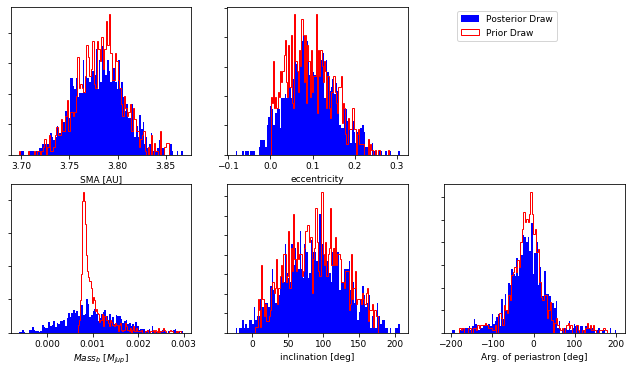

In [5]:
fig, axs = plt.subplots(2, 3,figsize=(11,6))
# sma
axs[0, 0].hist(kde.resample(len_pdf)[0,:],100,density=True,color='b',label='Posterior Draw',stacked=True)
axs[0, 0].hist(sma_prior,100,density=True,color='r',histtype = 'step',label='Prior Draw',stacked=True)#color='r')#
axs[0, 0].set_xlabel('SMA [AU]')
axs[0, 0].set_yticklabels([])
# ecc
axs[0, 1].hist(kde.resample(len_pdf)[1,:],100,density=True,color='b',label='Posterior Draw',stacked=True)
axs[0, 1].hist(ecc_prior,100,density=True,color='r',histtype = 'step',label='Prior Draw',stacked=True)#color='r')#
axs[0, 1].set_xlabel('eccentricity')
axs[0, 1].set_yticklabels([])
# mass
masskde_arr = kde.resample(len_pdf)[-1,:]
masskde_arr = masskde_arr[masskde_arr<0.003]
m1_prior_draw = m1_prior[m1_prior<0.003]
axs[1,0].hist(masskde_arr,100,density=True,color='b',label='Posterior Draw',stacked=True)
axs[1,0].hist((m1_prior_draw),100,density=True,color='r',histtype = 'step',label='Prior Draw',stacked=True)#color='r')#
axs[1, 0].set_xlabel('$Mass_b$ [$M_{Jup}$]')
axs[1, 0].set_yticklabels([])
# inc
axs[1,1].hist(np.rad2deg(kde.resample(len_pdf)[2,:]),100,density=True,color='b',label='Posterior Draw',stacked=True)
axs[1,1].hist(np.rad2deg(i_prior_samples),100,density=True,color='r',histtype = 'step',label='Prior Draw',stacked=True)#color='r')#
axs[1, 1].set_xlabel('inclination [deg]')
axs[1, 1].set_yticklabels([])
# w
axs[1,2].hist(np.rad2deg(kde.resample(len_pdf)[3,:]),100,density=True,color='b',label='Posterior Draw',stacked=True)
axs[1,2].hist(np.rad2deg(w_prior),100,density=True,color='r',histtype = 'step',label='Prior Draw',stacked=True)#color='r')#
axs[1, 2].set_xlabel('Arg. of periastron [deg]')
axs[1, 2].set_yticklabels([])

axs[0, 1].legend(bbox_to_anchor=(1.25, 1), loc='upper left', ncol=1)
axs[0, 2].axis('off')


As seen from the plot produced above, `m1` is not well fit by the KDE; the bandwidth selected (we selected the default) is too broad and the lower bound of the mass is not well reproduced.

## Select the KDE bandwidth

A temptation to fix the problem presented above, the oversmoothing of the data, would be to pick a very narrow bandwith, one that reproduces perfectly the data. However, the data from our posterior chains is finite, and contains throughout the distribution peaks and valleys that would introduce artifacts in the KDE fit contaminating the prior probabilities. 

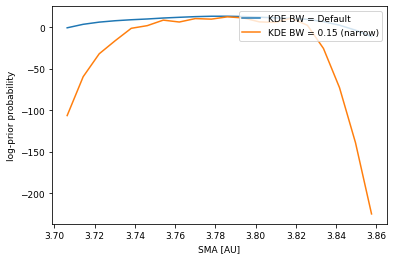

In [6]:
numtry_prior = 20
sma_arr = np.mean(sma_prior) * np.linspace(0.98,1.02,numtry_prior)

# Initialize KDE with default bandwidth
kde1 = gaussian_kde(values, bw_method=None) # None indicates that the KDE bandwidth is set to default
# Initialize KDE with narrow bandwidth
bw2 = 0.15
kde2 = gaussian_kde(values, bw_method=bw2)

lnprior_arr1 = np.zeros((numtry_prior))
lnprior_arr2 = np.zeros((numtry_prior))
for idx_prior,sma in enumerate(sma_arr):
    lnprior_arr1[idx_prior] = kde1.logpdf([sma, np.mean(ecc_prior),np.pi/2,np.mean(w_prior),np.mean(tau_prior),np.mean(m1_prior)])
    lnprior_arr2[idx_prior] = kde2.logpdf([sma, np.mean(ecc_prior),np.pi/2,np.mean(w_prior),np.mean(tau_prior),np.mean(m1_prior)])

plt.figure(100)
plt.plot(sma_arr,lnprior_arr1,label='KDE BW = Default')
plt.plot(sma_arr,lnprior_arr2,label='KDE BW = {} (narrow)'.format(bw2))
plt.xlabel('SMA [AU]')
plt.ylabel('log-prior probability')
plt.legend(loc='upper right')#, fontsize='x-large')


The plot above ilustrates that we cannot go arbitrarily narrow for the KDE bandwidth.

A way of choosing the KDE bandwidth is:
1. Pick an acceptable change in the median and 68th interval limits of the KDE fit w.r.t the actual posterior distribution. This will set a maximum acceptable bandwidth.
2. Pick an acceptable variation of the log-prior probability when evaluating the priors for a SMA around the prior median SMA. This will set a minimum acceptable bandwidth.

For this we will loop over a set of bandwidths computing the median and 68th interval limits, and for each bandwidth we will compute the variation of log-prior with a set of SMAs around the prior median SMA: we will fit a Gaussian and the standard deviation of the residuals to the fit will be our cost function.

Text(0.5, 1.0, '3. Std Dev of the Residuals to a Gaussian Fit of Plot #1')

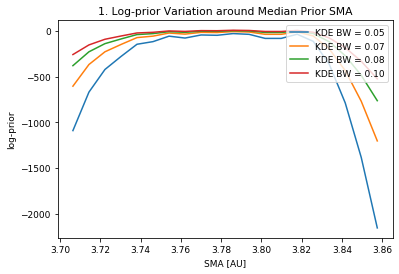

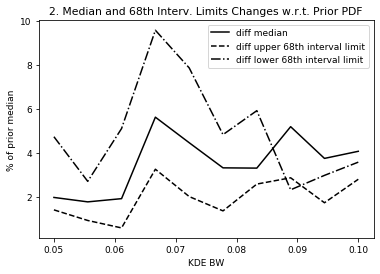

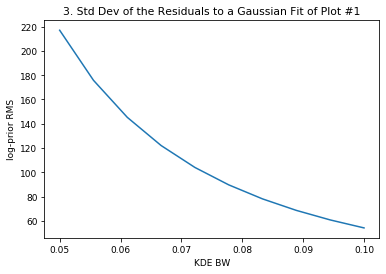

In [7]:
from scipy.optimize import curve_fit
def gaussian(x, amp, cen, wid,bias):
    return amp * np.exp(-(x-cen)**2 / wid)+bias

numtry_bw = 10
kde_bw_arr = np.linspace(0.05,0.1,numtry_bw)
diff_mean_arr = np.zeros((numtry_bw))
diff_p_arr = np.zeros((numtry_bw))
diff_m_arr = np.zeros((numtry_bw))
res_fit_prior2gauss = np.zeros((numtry_bw))

numtry_prior = 20
sma_arr = np.mean(sma_prior) * np.linspace(0.98,1.02,numtry_prior)

for idx_bw,kde_bw in enumerate(kde_bw_arr):
    kde = gaussian_kde(values, bw_method=kde_bw)
    
    # Check pdf
    lnprior_arr = np.zeros((numtry_prior))
    for idx_prior,sma in enumerate(sma_arr):
        lnprior_arr[idx_prior] = kde.logpdf([sma, np.mean(ecc_prior),np.pi/2,np.mean(w_prior),np.mean(tau_prior),np.mean(m1_prior)])
        
    # Quarentiles comparison
    masskde_arr = kde.resample(len_pdf)[5,:]
    masskde_arr = masskde_arr[masskde_arr<0.004]
    masskde_quantiles = np.quantile(masskde_arr*1000,[(1-0.68), 0.5, 0.5+(1-0.68)])
    massprior_quantiles = np.quantile(m1_prior_draw*1000,[(1-0.68), 0.5, 0.5+(1-0.68)])
    diff_mean_arr[idx_bw] = (masskde_quantiles[1]-massprior_quantiles[1])/massprior_quantiles[1]
    diff_p_arr[idx_bw] =((masskde_quantiles[1]-masskde_quantiles[0])-(massprior_quantiles[1]-massprior_quantiles[0]))/massprior_quantiles[1]
    diff_m_arr[idx_bw] =np.abs(((masskde_quantiles[2]-masskde_quantiles[1])-(massprior_quantiles[2]-massprior_quantiles[1]))/massprior_quantiles[1])
    
    # fit to Gaussian
    n = len(sma_arr) 
    mean = np.mean(sma_prior)                 
    sigma = 0.04   #note this correction
    best_vals, covar = curve_fit(gaussian, sma_arr, lnprior_arr,
                                 p0=[np.abs(np.max(lnprior_arr)-np.min(lnprior_arr)),np.mean(sma_prior),0.04,np.mean(lnprior_arr)*4])#[np.mean(lnprior_arr),mean,sigma])
    gauss_fit = gaussian(sma_arr,*best_vals)
    if idx_bw%3==0:
        plt.figure(101)
        plt.plot(sma_arr,lnprior_arr,label="KDE BW = {:.2f}".format(kde_bw))
    
    res_fit_prior2gauss[idx_bw] = np.std(gauss_fit-lnprior_arr)
plt.figure(101)
plt.legend(loc='upper right')
plt.xlabel('SMA [AU]')
plt.ylabel('log-prior')
plt.title('1. Log-prior Variation around Median Prior SMA')

plt.figure(301)
plt.plot(kde_bw_arr,diff_mean_arr*100,color='k',label='diff median')
plt.plot(kde_bw_arr,diff_p_arr*100,color='k',linestyle='--',label='diff upper 68th interval limit')
plt.plot(kde_bw_arr,diff_m_arr*100,color='k',linestyle='-.',label='diff lower 68th interval limit')
plt.xlabel('KDE BW')
plt.ylabel('% of prior median')
plt.legend(loc='upper right')#, fontsize='x-large')
plt.title('2. Median and 68th Interv. Limits Changes w.r.t. Prior PDF')

plt.figure(302)
plt.plot(kde_bw_arr,res_fit_prior2gauss,label='')
plt.xlabel('KDE BW')
plt.ylabel('log-prior RMS')
plt.title('3. Std Dev of the Residuals to a Gaussian Fit of Plot #1')


The above plots #2 and #3 give us the information to select the most adecuate KDE bandwidth. For instance, if we decide that a ~3-4% difference in the median and 68th interval limits is acceptable, that sets a maximum bandwidth of ~0.9 

To make a choice for the log-prior probability variation in the SMA range we picked, we can see what variation does the log-likelihood present for the same SMA range. For the same SMA range, we compute the log-likelihood of our model and see the peak-to-valley to assess what variation we want to allow for a narrow bandwidth. 

Once you've chosen the bandwidth that best fits your posteriors you can use them as priors for a MCMC fit. Link to [MCMC tutotial](MCMC_tutorial.ipynb).
